In [1]:
# !pip install tensorflow pandas scikit-learn matplotlib

In [1]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 로드
# df = pd.read_csv('/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/train.csv')
df = pd.read_csv('./skku-2024-1-machine-learning-third-project/train.csv')

# train-test 분리
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


In [3]:
df.shape

(3785, 2)

In [4]:
# df2 = pd.read_csv("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/test.csv")
df2 = pd.read_csv("skku-2024-1-machine-learning-third-project/test.csv")
df2

,image_name
0,6417.jpg
1,6418.jpg
2,6420.jpg
3,6422.jpg
4,6425.jpg
...,...
435,7132.jpg
436,7134.jpg
437,7135.jpg
438,7136.jpg


In [5]:
# import os
# import shutil

# dir = r"/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/SceneImages"

# # train_lst = df['image_name'].values.tolist()

# # for i in train_lst:
# #     shutil.move(dir+"/"+i,"/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/train")

# # files = os.listdir(dir)
# # for i in (files):
# #     shutil.move(dir+"/"+i,"/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/test")

# print(len(os.listdir("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/train")))
# print(len(os.listdir("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/test")))
# print(len(os.listdir("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/SceneImages")))

In [6]:
# print(set(os.listdir("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/train")) == set(df['image_name'].values.tolist()))
# print(set(os.listdir("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/test")) == set(df2['image_name'].values.tolist()))

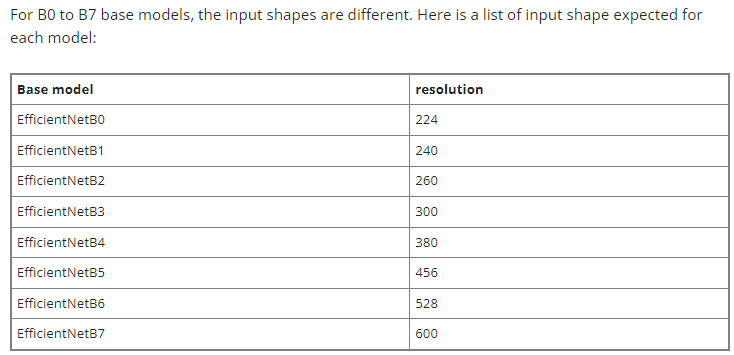

https://discuss.pytorch.org/t/input-size-for-efficientnet-versions-from-torchvision-models/140525

In [7]:
sizes = {
    'b0': (256, 224), 'b1': (256, 240), 'b2': (288, 288), 'b3': (320, 300),
    'b4': (384, 380), 'b5': (489, 456), 'b6': (561, 528), 'b7': (633, 600),
}
resoultion = sizes['b4']
resoultion

(384, 380)

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize(resoultion),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=resoultion, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# train_dataset = CustomDataset(train_df, '/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/train', transform=transform)
# val_dataset = CustomDataset(val_df, '/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/train', transform=transform)
train_dataset = CustomDataset(train_df, 'skku-2024-1-machine-learning-third-project/train', transform=transform)
val_dataset = CustomDataset(val_df, 'skku-2024-1-machine-learning-third-project/train', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 모델 정의
model = models.efficientnet_b4(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_df['label'].unique()))

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


c:\Users\ben81\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ben81\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
project_name = 'b4_resoultion_changed'

model_save_path = project_name+'.pth'
df_save_path = './skku-2024-1-machine-learning-third-project/' + project_name + '.csv'
model_save_path, df_save_path

('b4_resoultion_changed.pth',
 './skku-2024-1-machine-learning-third-project/b4_resoultion_changed.csv')

In [12]:
device

device(type='cuda')

In [13]:
import os

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습 함수 정의
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=200):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        model.eval()
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(val_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_acc and epoch>45:
            best_acc = val_acc
            # torch.save(model.state_dict(), '/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/best_model_200_twoaug.pth')
            torch.save(model.state_dict(), model_save_path)

    print('Best Val Acc: {:4f}'.format(best_acc))

# 모델 학습
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)


Epoch 0/99, Loss: 1.0642, Acc: 0.6830, Val Acc: 0.8573
Epoch 1/99, Loss: 0.3850, Acc: 0.8603, Val Acc: 0.8943
Epoch 2/99, Loss: 0.2810, Acc: 0.8993, Val Acc: 0.8956
Epoch 3/99, Loss: 0.2481, Acc: 0.9164, Val Acc: 0.9036
Epoch 4/99, Loss: 0.2205, Acc: 0.9240, Val Acc: 0.9062
Epoch 5/99, Loss: 0.1886, Acc: 0.9369, Val Acc: 0.9221
Epoch 6/99, Loss: 0.1585, Acc: 0.9425, Val Acc: 0.9273
Epoch 7/99, Loss: 0.1524, Acc: 0.9455, Val Acc: 0.9115
Epoch 8/99, Loss: 0.1206, Acc: 0.9581, Val Acc: 0.9247
Epoch 9/99, Loss: 0.1122, Acc: 0.9600, Val Acc: 0.9155
Epoch 10/99, Loss: 0.0871, Acc: 0.9723, Val Acc: 0.9168
Epoch 11/99, Loss: 0.0902, Acc: 0.9680, Val Acc: 0.9207
Epoch 12/99, Loss: 0.0798, Acc: 0.9696, Val Acc: 0.9207
Epoch 13/99, Loss: 0.0616, Acc: 0.9789, Val Acc: 0.9168
Epoch 14/99, Loss: 0.0511, Acc: 0.9825, Val Acc: 0.9221
Epoch 15/99, Loss: 0.0468, Acc: 0.9868, Val Acc: 0.9207
Epoch 16/99, Loss: 0.0429, Acc: 0.9884, Val Acc: 0.9022
Epoch 17/99, Loss: 0.0340, Acc: 0.9898, Val Acc: 0.9128
Ep

In [ ]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms


# 모델 로드
# model.load_state_dict(torch.load('/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/best_model_200_twoaug.pth'))
model.load_state_dict(torch.load(model_save_path))
model.eval()

# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize(resoultion),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_image(image_path, model):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    return preds.item()

# 예측할 이미지 리스트 생성
image_names = df2['image_name'].values.tolist()

# 예측 결과 저장을 위한 리스트
results = []

# 예측 및 결과 저장
for image_name in image_names:
    image_path = os.path.join('./skku-2024-1-machine-learning-third-project/test', image_name)
    predicted_class = predict_image(image_path, model)
    results.append({'image_name': image_name, 'label': predicted_class})

# 리스트를 데이터프레임으로 변환
result_df = pd.DataFrame(results)

# 결과 CSV 파일로 저장
# result_df.to_csv('/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/predictions_200.csv', index=False)
result_df.to_csv(df_save_path, index=False)

print(df_save_path)


Predictions saved to predictions.csv


In [15]:
result_df

,image_name,label
0,6417.jpg,0
1,6418.jpg,3
2,6420.jpg,0
3,6422.jpg,2
4,6425.jpg,5
...,...,...
435,7132.jpg,5
436,7134.jpg,4
437,7135.jpg,4
438,7136.jpg,4


In [16]:
df3 = pd.read_csv("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/submission.csv")
df3

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/submission.csv'

Ensemble

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader


# 모델 로드 및 출력층 수정
def load_model(model_name, num_classes):
    if model_name == 'efficientnet_b7':
        model = models.efficientnet_b7(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError("Unsupported model type")
    return model

# 모델 목록
model_names = ['efficientnet_b7', 'resnet50', 'densenet121']
num_classes = 6
models_list = [load_model(name, num_classes) for name in model_names]

# 옵티마이저 및 손실 함수 정의
optimizers = [optim.Adam(model.parameters(), lr=1e-3) for model in models_list]
criterion = nn.CrossEntropyLoss()

# 모델 학습 함수
def train_model(model, optimizer, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")
    return model

# 모델 학습
trained_models = [train_model(model, optimizer) for model, optimizer in zip(models_list, optimizers)]

# 앙상블 예측 함수
def ensemble_predict(models, inputs):
    outputs = [model(inputs) for model in models]
    avg_output = torch.mean(torch.stack(outputs), dim=0)
    return avg_output

# 모델 평가
def evaluate(models):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    correct = 0
    total = 0
    for model in models:
        model.to(device)
        model.eval()
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = ensemble_predict(models, inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return accuracy

accuracy = evaluate(trained_models)
print(f"Ensemble Accuracy: {accuracy}")
